# Credit Card Default Prediction

In [42]:
# import packages

from sklearn import tree 
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split 
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn.preprocessing import normalize, scale, Normalizer, StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC, SVR, LinearSVC
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.preprocessing import FunctionTransformer


import numpy as np
import pandas as pd
import pickle 


In [43]:
import matplotlib.pyplot as plt 

import seaborn as sns
sns.set(style="white") #white background style for seaborn plots
sns.set(style="whitegrid", color_codes=True)

In [44]:
import altair as alt
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier, AdaBoostClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import RFE
from sklearn.metrics import roc_auc_score
import time

### Introduction

For this problem, I will use [UCI default of credit card clients Data Set](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients). In this data set, there are 30,000 examples and 24 features, and the goal is to estimate whether a person will default (fail to pay) their credit card bills; this column is labeled "default payment next month" in the data. The rest of the columns can be used as features.


In [46]:
# load the data set

cc = pd.read_excel('credit.xls',header =1)

In [47]:
# take a look at 

cc.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [48]:
# drop the ID column
cc_df = cc.drop(columns=['ID'])

In [49]:
# read name the target column as 'y'

cc_df = cc_df.rename(columns={'default payment next month': 'y'})

In [50]:
### Create X and y

X = cc_df.drop(['y'], axis=1)
y = cc_df['y']

In [51]:
X.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,20000,2,2,1,24,2,2,-1,-1,-2,...,689,0,0,0,0,689,0,0,0,0
1,120000,2,2,2,26,-1,2,0,0,0,...,2682,3272,3455,3261,0,1000,1000,1000,0,2000
2,90000,2,2,2,34,0,0,0,0,0,...,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
3,50000,2,2,1,37,0,0,0,0,0,...,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
4,50000,1,2,1,57,-1,0,-1,0,0,...,35835,20940,19146,19131,2000,36681,10000,9000,689,679


In [52]:
y.head()

0    1
1    1
2    0
3    0
4    0
Name: y, dtype: int64

In [53]:

def split_data(X, y):
    """
    Shows train and test error 
    Parameters
    ----------
    model: sklearn classifier model
        The sklearn model
    X: numpy.ndarray        
        The X part (features) of the dataset
    y numpy.ndarray
        The y part (target) of the dataset
    Returns
    -------        
        X_train: numpy.ndarray
            The X part of the train dataset
        y_train: numpy.ndarray  
            The y part of the train dataset
        X_valid: numpy.ndarray  
            The X part of the validation dataset        
        y_valid
            The y part of the validation dataset        
        X_trainvalid
            The X part of the train+validation dataset        
        y_trainvalid
            The y part of the train+validation dataset        
        X_test
            The X part of the test dataset        
        y_test            
            The y part of the test dataset        
    """
    X_trainvalid, X_test, y_trainvalid, y_test = train_test_split(X, y, train_size=0.8, random_state=22)
    X_train, X_valid, y_train, y_valid = train_test_split(X_trainvalid, y_trainvalid, 
                                                          train_size=0.75, random_state=22)

    print("Number of training examples:", len(y_train))
    print("Number of validation examples:", len(y_valid))
    print("Number of test examples:", len(y_test))
    
    return X_train, y_train, X_valid, y_valid, X_trainvalid, y_trainvalid, X_test, y_test

In [54]:
X_train, y_train, X_valid, y_valid, X_trainvalid, y_trainvalid, X_test, y_test = split_data(X,y)

Number of training examples: 18000
Number of validation examples: 6000
Number of test examples: 6000


### (2) EDA


In [55]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18000 entries, 4858 to 17127
Data columns (total 23 columns):
LIMIT_BAL    18000 non-null int64
SEX          18000 non-null int64
EDUCATION    18000 non-null int64
MARRIAGE     18000 non-null int64
AGE          18000 non-null int64
PAY_0        18000 non-null int64
PAY_2        18000 non-null int64
PAY_3        18000 non-null int64
PAY_4        18000 non-null int64
PAY_5        18000 non-null int64
PAY_6        18000 non-null int64
BILL_AMT1    18000 non-null int64
BILL_AMT2    18000 non-null int64
BILL_AMT3    18000 non-null int64
BILL_AMT4    18000 non-null int64
BILL_AMT5    18000 non-null int64
BILL_AMT6    18000 non-null int64
PAY_AMT1     18000 non-null int64
PAY_AMT2     18000 non-null int64
PAY_AMT3     18000 non-null int64
PAY_AMT4     18000 non-null int64
PAY_AMT5     18000 non-null int64
PAY_AMT6     18000 non-null int64
dtypes: int64(23)
memory usage: 3.3 MB


Note: all column are integers and there are no missing data.

In [56]:
X_train.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,...,18000.000000,18000.000000,18000.000000,18000.000000,18000.00000,1.800000e+04,18000.000000,18000.000000,18000.000000,18000.000000
mean,166918.315556,1.604056,1.850056,1.552833,35.388833,-0.015944,-0.133722,-0.159722,-0.214389,-0.262500,...,46987.866611,43332.309611,40192.567167,38774.752611,5725.34550,5.773996e+03,5251.182389,4735.146333,4766.516500,5198.747222
std,129581.922701,0.489066,0.788773,0.521325,9.168241,1.113045,1.190204,1.202942,1.175137,1.141977,...,68678.816258,64440.206073,60625.793607,59466.664180,17222.84963,2.217529e+04,18517.641142,15300.716847,15382.522181,17704.627362
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-157264.000000,-81334.000000,-81334.000000,-209051.000000,0.00000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2663.750000,2290.250000,1716.500000,1279.500000,1000.00000,8.200000e+02,390.000000,280.000000,234.750000,132.750000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,20159.000000,19111.000000,18073.500000,16818.000000,2138.00000,2.013500e+03,1824.500000,1500.000000,1505.000000,1500.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,60380.500000,54909.000000,50134.750000,49169.000000,5014.25000,5.000000e+03,4429.500000,4006.000000,4100.000000,4003.000000
max,1000000.000000,2.000000,6.000000,3.000000,75.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,855086.000000,891586.000000,927171.000000,961664.000000,873552.00000,1.227082e+06,896040.000000,621000.000000,426529.000000,528666.000000


Note: not many new findings here, but all the features are not in the same scale here. I may apply some scalers later.

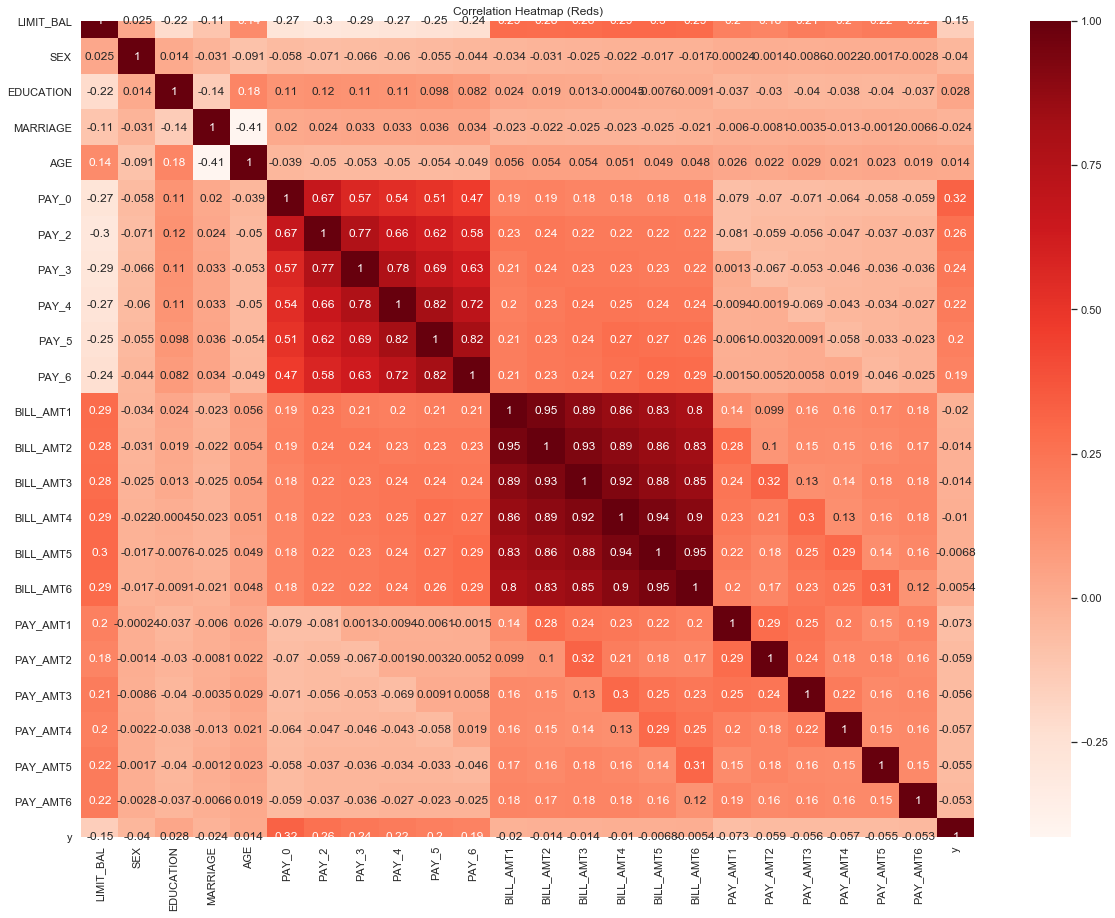

In [57]:
# create a heatmap of correlations between all pairs of features

plt.subplots(figsize=(20,15))
ax = plt.axes()
ax.set_title("Correlation Heatmap (Reds)")
corr = cc_df.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
           cmap="Reds",annot = True)
plt.show()

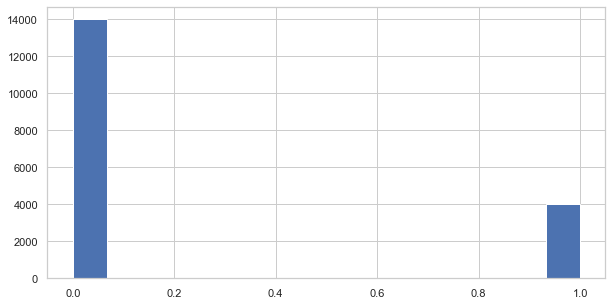

In [58]:
# show target's class distribution in a plot

%matplotlib inline
y_train.hist(bins=15, figsize=(10,5))
plt.show()

There are some imbalances in the target, not too severe, I will not address it.

In [59]:
print('In the training set, the non-default percentage default is', round(y_train.value_counts()[0]/len(y_train),3))

In the training set, the non-default percentage default is 0.776


If the classifier just predicts Not default(0), the model should perform significantly better than 0.776 to be considered as an effective classifier.

### (3) Baseline model


In [60]:
# try the default strategy is strategy =”stratified”

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train)
print(dummy_clf.score(X_train,y_train))
print(dummy_clf.score(X_valid,y_valid))

0.6520555555555556
0.6505


/Users/tonyhuang/opt/anaconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


In [61]:
# try the default strategy is strategy = "most_frequent"

dummy_clf = DummyClassifier(strategy = "most_frequent")
dummy_clf.fit(X_train, y_train)
print(dummy_clf.score(X_train,y_train))
print(dummy_clf.score(X_valid,y_valid))

0.7764444444444445
0.777


The dummy classifier surely will not provide satisfactory result. I will try other method and other metrics.

### (4) Logistic Regression


In [62]:

lr = LogisticRegression(max_iter = 10000)
lr.fit(X_train,y_train)

print(lr.score(X_train,y_train))
print(lr.score(X_valid,y_valid))

0.7763333333333333
0.777


In [63]:
def display_confusion_matrix_classification_report(model, X_valid, y_valid, 
                                                   labels=['Non fraud', 'Fraud']):
    """
    Displays confusion matrix and classification report. 
    
    Arguments
    ---------     
    model -- sklearn classifier model
        The sklearn model
    X_valid -- numpy.ndarray        
        The X part of the validation set
    y_valid -- numpy.ndarray
        The y part of the validation set       

    Keyword arguments:
    -----------
    labels -- list (default = ['Non fraud', 'Fraud'])
        The labels shown in the confusion matrix
    Returns
    -------
        None
    """
    ### Display confusion matrix 
    disp = plot_confusion_matrix(model, X_valid, y_valid,
                                 display_labels=labels,
                                 cmap=plt.cm.Blues, 
                                 values_format = 'd')
    disp.ax_.set_title('Confusion matrix for the dataset')

    ### Print classification report
    print(classification_report(y_valid, model.predict(X_valid)))


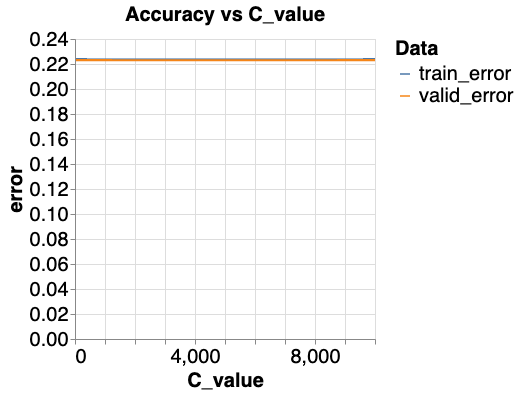

In [64]:
# calculation loop

C_dict = {'C_value':[], 'train_error':[], 'valid_error': []}
for c in 10.0**np.arange(-5,5):
    model = LogisticRegression(C = c, random_state=1 , max_iter = 10000).fit(X_train, y_train)  
    C_dict['C_value'].append(c)    
    C_dict['train_error'].append(1 - model.score(X_train, y_train))
    C_dict['valid_error'].append(1 - model.score(X_valid, y_valid))
C_dict_df = pd.DataFrame(C_dict)
C_dict_df = C_dict_df.melt(id_vars='C_value',
                                 value_name='error',
                                 var_name='Data') # melt datadframe to work with altair


# plot
alt.Chart(C_dict_df).mark_line().encode(
    x="C_value",
    y="error",
    color='Data'
).properties(
    title='Accuracy vs C_value'
).properties(
    width=300,
    height=300
).configure_title(
    fontSize=20
).configure_axis(
    labelFontSize=20,
    titleFontSize=20
).configure_legend(
    titleFontSize=20,
    labelFontSize=20
)

In [65]:
print('The lowest validation error is', 1-model.score(X_valid, y_valid))

The lowest validation error is 0.22299999999999998


#### I will try other metrics 

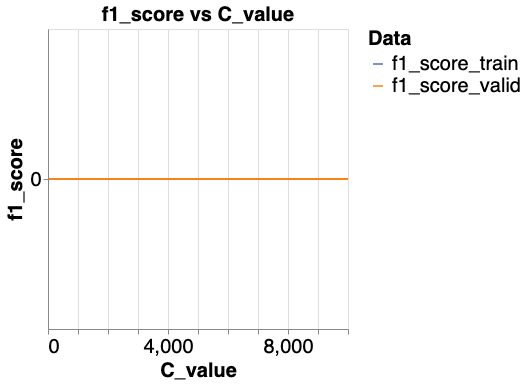

In [66]:
# Try F1 score

C_dict = {'C_value':[], 'f1_score_train':[], 'f1_score_valid': []}
for c in 10.0**np.arange(-5,5):
    
    model = LogisticRegression(C = c, random_state=1 , max_iter = 10000).fit(X_train, y_train)  
    C_dict['C_value'].append(c) 
    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_valid)
    C_dict['f1_score_train'].append(f1_score(y_train, y_train_pred))
    C_dict['f1_score_valid'].append(f1_score(y_valid, y_valid_pred))
C_dict_df = pd.DataFrame(C_dict)
C_dict_df = C_dict_df.melt(id_vars='C_value',
                                 value_name='f1_score',
                                 var_name='Data') # melt datadframe to work with altair


# plot
alt.Chart(C_dict_df).mark_line().encode(
    x="C_value",
    y="f1_score",
    color='Data'
).properties(
    title='f1_score vs C_value'
).properties(
    width=300,
    height=300
).configure_title(
    fontSize=20
).configure_axis(
    labelFontSize=20,
    titleFontSize=20
).configure_legend(
    titleFontSize=20,
    labelFontSize=20
)

/Users/tonyhuang/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.78      1.00      0.87      4662
           1       0.00      0.00      0.00      1338

    accuracy                           0.78      6000
   macro avg       0.39      0.50      0.44      6000
weighted avg       0.60      0.78      0.68      6000



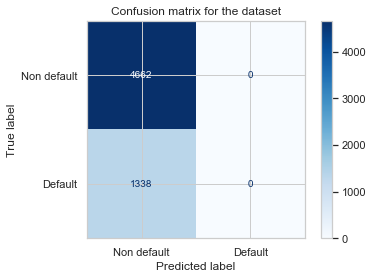

In [67]:
# try generating a confusion matrix with C = 1

model = LogisticRegression(C = 1, random_state=1 , max_iter = 10000).fit(X_train, y_train)  
display_confusion_matrix_classification_report(model, X_valid, y_valid, 
                                               labels=['Non default', 'Default'])

Because the model always predicts Non-default, even we use `f1 score` as the metric, the f1_score for predicting default is 0. The logistic regression is doing nothing different from Dummy Classifier.

### (5) Feature transformations


In [68]:

X_train.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'],
      dtype='object')

In [69]:
# Split the features into numeric features and categorical features
numeric_features = ['LIMIT_BAL','AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
categorical_features = ['SEX','EDUCATION','MARRIAGE']

In [70]:
# Create the transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('scale', StandardScaler(), numeric_features),
        ('ohe', OneHotEncoder(drop="first"), categorical_features)])

In [71]:
# Apply data transformations and convert back to dataframe

X_train = pd.DataFrame(preprocessor.fit_transform(X_train),
                       index=X_train.index,
                       columns=(numeric_features +
                                list(preprocessor.named_transformers_['ohe'].get_feature_names(categorical_features))))

X_valid = pd.DataFrame(preprocessor.transform(X_valid),
                      index=X_valid.index,
                      columns=X_train.columns)

X_trainvalid = pd.DataFrame(preprocessor.transform(X_trainvalid),
                      index=X_trainvalid.index,
                      columns=X_train.columns)


X_test = pd.DataFrame(preprocessor.transform(X_test),
                      index=X_test.index,
                      columns=X_train.columns)




              precision    recall  f1-score   support

           0       0.82      0.97      0.89      4662
           1       0.69      0.26      0.37      1338

    accuracy                           0.81      6000
   macro avg       0.75      0.61      0.63      6000
weighted avg       0.79      0.81      0.77      6000



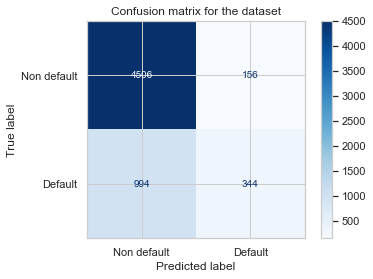

In [72]:
# try logistic regression using new dataset

model = LogisticRegression(C = 1, random_state=1 , max_iter = 10000).fit(X_train, y_train)  
display_confusion_matrix_classification_report(model, X_valid, y_valid, 
                                               labels=['Non default', 'Default'])

Yes, features transformations improves my result. For predicting default, the `f1_score` went from 0.0 to 0.37, the accuracy went from 0.77 to 0.81.

### (6) Different classifiers


In [73]:
classifiers = {
    'logistic_regression' :LogisticRegression(max_iter = 10000),
    'random forest' : RandomForestClassifier(),
    'lgbm'           : LGBMClassifier(),
    'sklearn NN'    : MLPClassifier(max_iter = 1000)
}

train_scores = dict()
valid_scores = dict()
training_times = dict()
train_f1 = dict()
valid_f1 = dict()

for classifier_name, classifier_obj in classifiers.items():
    print("Fitting", classifier_name)
    t = time.time()
    classifier_obj.fit(X_train, y_train.to_numpy().ravel())
    
    train_predict = classifier_obj.predict(X_train)
    valid_predict = classifier_obj.predict(X_valid)
    
    training_times[classifier_name] = time.time() - t
    train_scores[classifier_name] = classifier_obj.score(X_train, y_train)
    valid_scores[classifier_name] = classifier_obj.score(X_valid, y_valid)
    
    train_f1[classifier_name] = f1_score(y_train, train_predict)
    valid_f1[classifier_name] = f1_score(y_valid, valid_predict)

data = {"train accuracy": train_scores, "valid accuracy" : valid_scores, "training time (s)" : training_times, "train f1 score": train_f1, "valid f1 score": valid_f1}
df_6 = pd.DataFrame(data, columns=data.keys())
df_6.index = list(classifiers.keys())
df_6

Fitting logistic_regression
Fitting random forest
Fitting lgbm
Fitting sklearn NN


,train accuracy,valid accuracy,training time (s),train f1 score,valid f1 score
logistic_regression,0.809278,0.808333,0.369830,0.368353,0.374320
random forest,0.999556,0.810333,5.226644,0.999005,0.467228
lgbm,0.847556,0.817667,0.343927,0.564168,0.481025
sklearn NN,0.841444,0.808000,22.747587,0.552384,0.456604


### (7) Hyperparameter optimization


In [74]:
def show_results(model,Xr,yt,Xv,yv,labels=['Non default', 'Default']):
    """
    after fitting the model, print the training error, validation error and print a confusion matrix
    """
    print('The training accuracy',model.score(Xr,yt))
    print('The validation accuracy',model.score(Xv,yv))
    print('The validation f1 score', f1_score(yv, model.predict(Xv)))
    display_confusion_matrix_classification_report(model, Xv, yv, 
                                               labels=['Non default', 'Default'])
    

In [75]:

n_estimators = [5,10,20,30,40,50]

max_depth = [int(x) for x in np.arange(1,10)]

random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth}


{'n_estimators': 50, 'max_depth': 8}
The training accuracy 0.8416111111111111
The validation accuracy 0.8115
The validation f1 score 0.457033125300048
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      4662
           1       0.64      0.36      0.46      1338

    accuracy                           0.81      6000
   macro avg       0.74      0.65      0.67      6000
weighted avg       0.79      0.81      0.79      6000



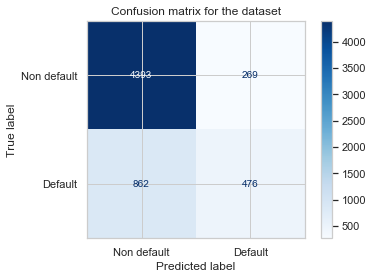

In [76]:
# doing the search again using f1 as the scoring

rf = RandomForestClassifier()

rsc = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 40, cv = 5,random_state=42,scoring = 'f1')
rsc.fit(X_train, y_train) 
print(rsc.best_params_)
best_rf = rsc.best_estimator_
show_results(best_rf,X_train, y_train,X_valid, y_valid)

In [77]:
# For LGBM
# the parameters for LGBM

param_lgbm ={
             'reg_alpha': [0, 1e-1, 1, 2, 5]}

{'reg_alpha': 2}
The training accuracy 0.8443888888888889
The validation accuracy 0.8145
The validation f1 score 0.47025226082817706
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      4662
           1       0.65      0.37      0.47      1338

    accuracy                           0.81      6000
   macro avg       0.74      0.66      0.68      6000
weighted avg       0.80      0.81      0.79      6000



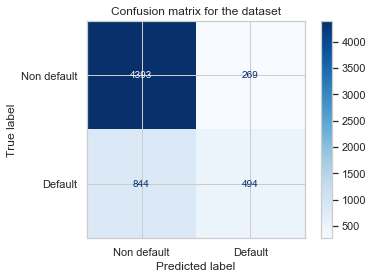

In [78]:
# doing the grid search for LGBM 

lgc = LGBMClassifier()

gsc_lgc = GridSearchCV(estimator = lgc, param_grid = param_lgbm, cv = 5,scoring = 'f1')
gsc_lgc.fit(X_train, y_train) 
print(gsc_lgc.best_params_)
best_lgc = gsc_lgc.best_estimator_
show_results(best_lgc,X_train, y_train,X_valid, y_valid)

In [79]:
# For SKNN

# Tune the parameters for SKNN

parameter_space = {
    'alpha': [0.0001, 0.05]
}

{'alpha': 0.05}
The training accuracy 0.8291666666666667
The validation accuracy 0.8065
The validation f1 score 0.3975090814737935
              precision    recall  f1-score   support

           0       0.82      0.96      0.88      4662
           1       0.65      0.29      0.40      1338

    accuracy                           0.81      6000
   macro avg       0.74      0.62      0.64      6000
weighted avg       0.78      0.81      0.78      6000



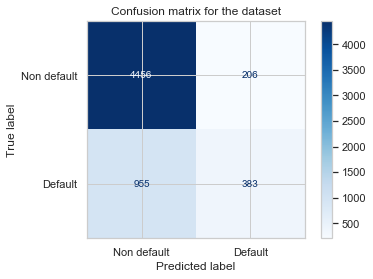

In [80]:
# doing the grid search for MLP

mlp = MLPClassifier(max_iter = 1000)

gsc_mlp = GridSearchCV(estimator = mlp, param_grid = parameter_space, cv = 3,scoring = 'f1')
gsc_mlp.fit(X_train, y_train)
print(gsc_mlp.best_params_)
best_mlp = gsc_mlp.best_estimator_
show_results(best_mlp,X_train, y_train,X_valid, y_valid)

### (8) Feature selection


In [81]:
# see how many features we have

len(X_train.columns)

30

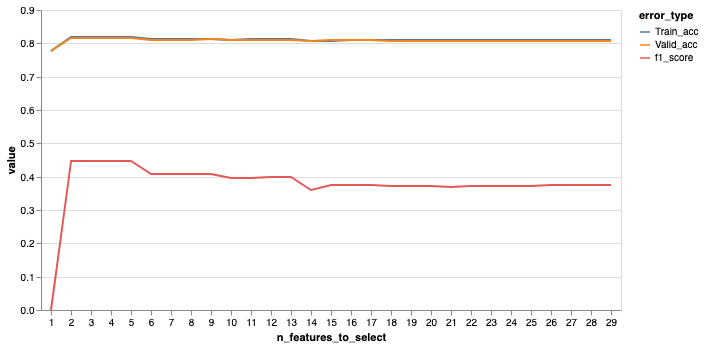

In [82]:
df = pd.DataFrame(columns = ['n_features_to_select','Train_acc', 'Valid_acc','f1_score']) 

for n in range(1,30):
    lr = LogisticRegression(max_iter = 10000)
    rfe = RFE(estimator = lr, n_features_to_select = n)
    rfe.fit(X_train, y_train)
    X_train_sel = X_train.iloc[:, rfe.support_]
    X_valid_sel = X_valid.iloc[:, rfe.support_]
    lr.fit(X_train_sel,y_train)
    train_acc = lr.score(X_train_sel,y_train)
    valid_acc = lr.score(X_valid_sel,y_valid)
    f1 = f1_score(y_valid, lr.predict(X_valid_sel))
    df = df.append({'n_features_to_select':n, 'Train_acc':train_acc, 'Valid_acc':valid_acc,'f1_score':f1},ignore_index = True)

df_melt = pd.melt(df, id_vars=['n_features_to_select'], value_vars=['Train_acc','Valid_acc','f1_score'],
            var_name='error_type', value_name='value')


alt.Chart(df_melt).mark_line().encode(
    x='n_features_to_select:N',
    y='value:Q',
    color = 'error_type'
).configure_scale(round = True).configure_axisX(labelAngle=0)


In [83]:
# See what features are important when selecting 2 features

lr = LogisticRegression(max_iter = 10000)
rfe = RFE(estimator = lr, n_features_to_select = 2)
rfe.fit(X_train, y_train)
X_train_sel = X_train.iloc[:, rfe.support_]
print('Two selected features are:', X_train_sel.columns)

Two selected features are: Index(['PAY_0', 'EDUCATION_5'], dtype='object')


The training accuracy 0.818
The validation accuracy 0.8165
The validation f1 score 0.44645550527903477
              precision    recall  f1-score   support

           0       0.83      0.96      0.89      4662
           1       0.68      0.33      0.45      1338

    accuracy                           0.82      6000
   macro avg       0.76      0.64      0.67      6000
weighted avg       0.80      0.82      0.79      6000



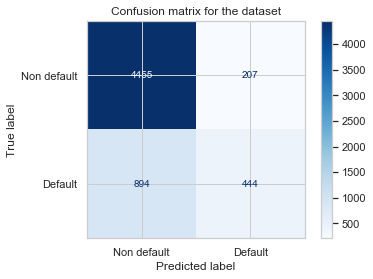

In [84]:
lr_sel = LogisticRegression(max_iter = 10000)
rfe = RFE(estimator = lr, n_features_to_select = 2)
rfe.fit(X_train, y_train)
X_train_sel = X_train.iloc[:, rfe.support_]
X_valid_sel = X_valid.iloc[:, rfe.support_]
lr_sel.fit(X_train_sel,y_train)
show_results(lr_sel,X_train_sel, y_train,X_valid_sel, y_valid)

### (9) Interpretation and feature importance 


In [86]:
import eli5

/Users/tonyhuang/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/tonyhuang/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


In [87]:
features = list(X_train_sel.columns)
eli5.explain_weights(lr_sel, feature_names = features)

Weight?,Feature
+0.825,PAY_0
-1.390,<BIAS>
-1.844,EDUCATION_5


The `PAY_0` (the latest repayment status of September, 2005) and `EDUCATION_5`(the education level being "unknown") are the two strong predictors of the probability of default or not.

### (10) Results on the test set


In [88]:
classifiers = {
    'logistic_regression' :LogisticRegression(max_iter = 10000),
    'random forest' : RandomForestClassifier(),
    'lgbm'           : LGBMClassifier(),
    'sklearn NN'    : MLPClassifier()
}

train_scores = dict()
valid_scores = dict()
training_times = dict()
train_f1 = dict()
valid_f1 = dict()

for classifier_name, classifier_obj in classifiers.items():
    print("Fitting", classifier_name)
    t = time.time()
    classifier_obj.fit(X_train_sel, y_train.to_numpy().ravel())
    
    train_predict = classifier_obj.predict(X_train_sel)
    valid_predict = classifier_obj.predict(X_valid_sel)
    
    training_times[classifier_name] = time.time() - t
    train_scores[classifier_name] = classifier_obj.score(X_train_sel, y_train)
    valid_scores[classifier_name] = classifier_obj.score(X_valid_sel, y_valid)
    
    train_f1[classifier_name] = f1_score(y_train, train_predict)
    valid_f1[classifier_name] = f1_score(y_valid, valid_predict)
    
#     display_confusion_matrix_classification_report(classifier_obj, X_valid_sel, y_valid, 
#                                                labels=['Non default', 'Default'])

data = {"train_acc": train_scores, "valid_acc" : valid_scores, "training time (s)" : training_times, "train f1 score": train_f1, "valid f1 score": valid_f1}
df_10 = pd.DataFrame(data, columns=data.keys())
df_10.index = list(classifiers.keys())
df_10

Fitting logistic_regression
Fitting random forest
Fitting lgbm
Fitting sklearn NN


,train_acc,valid_acc,training time (s),train f1 score,valid f1 score
logistic_regression,0.818000,0.816500,0.023554,0.444181,0.446456
random forest,0.818222,0.816833,0.520354,0.442969,0.445789
lgbm,0.818111,0.816667,0.096370,0.441297,0.443320
sklearn NN,0.818056,0.816500,1.987650,0.443311,0.445340


#### All model are performing almost the same, then I will pick the simplest: logistic regression.

In [89]:
# Select only the same features in step 8 for the trainvalid set and test set

X_trainvalid_sel = X_trainvalid.iloc[:, rfe.support_]
X_test_sel = X_test.iloc[:, rfe.support_]

In [90]:
# fit the model 

lr_full = LogisticRegression(max_iter = 10000)
lr_full.fit(X_trainvalid_sel, y_trainvalid)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

The training accuracy 0.817625
The validation accuracy 0.8291666666666667
The validation f1 score 0.44981213097155126
              precision    recall  f1-score   support

           0       0.84      0.96      0.90      4726
           1       0.71      0.33      0.45      1274

    accuracy                           0.83      6000
   macro avg       0.78      0.65      0.67      6000
weighted avg       0.81      0.83      0.80      6000



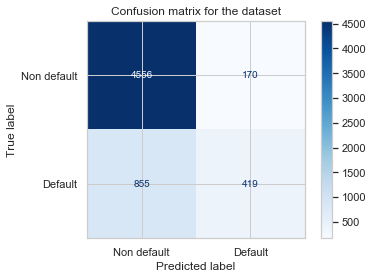

In [91]:
show_results(lr_full,X_trainvalid_sel, y_trainvalid,X_test_sel, y_test)

### (12) Summary of results


In [99]:

data_12.keys()

dict_keys(['train_acc', 'test_acc', 'train_f1_score', 'test_f1_score'])

In [114]:
train_score = lr_full.score(X_trainvalid_sel, y_trainvalid)
test_score = lr_full.score(X_test_sel, y_test)
train_f1 = f1_score(y_trainvalid, lr_full.predict(X_trainvalid_sel))
test_f1 = f1_score(y_test, lr_full.predict(X_test_sel))

data_12 = {"train_acc": train_score, "test_acc" : test_score, "train_f1_score": train_f1, "test_f1_score": test_f1}
df_12 = pd.DataFrame(data_12,index=['logistic regression'])
df_12

,train_acc,test_acc,train_f1_score,test_f1_score
logistic regression,0.817625,0.829167,0.444755,0.449812


#### Concluding marks

From the accuracy perspective, it seems our final logistic regression classifier did ok, the train accuracy is 0.817625 and the test accuracy is 0.829167. However, from f1 perspective, it tells another story, it is only at around 0.44. And the reason is probably because it did poorly in predicting the `default` class.

#### Thoughts:

The test accuracy is even higher training accuracy, it is somehow strange. I guess the reason is: with just predicting the non default, even the dummy classifier could get a accuracy of around 77%, and the final logistic regression classifier did not learn enough from the class 'default', that is why the training f1 score is low. 



#### improvements

When I was training the model above, I did not deal with the class imbalances, I think one potential improvement one can make is to use weight, oversample, or undersample to deal with the imbalance.
